# Session 02

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from fredapi import Fred
from dotenv import load_dotenv

# Load environment variables
load_dotenv()
fred_api_key = os.getenv('FRED_API_KEY')
fred = Fred(api_key=fred_api_key)

print(f"FRED API key loaded: {fred_api_key[:10]}...")

FRED API key loaded: 1383c60c37...


## FRED Series IDs for Treasury Securities Holdings

Based on the Federal Reserve's Financial Accounts of the United States (Z.1), Table L.210:

- **FGTSL**: Total Treasury Securities Liabilities (for calculating percentages)
- **BOGZ1FL713061103Q**: Monetary Authority (Federal Reserve)
- **BOGZ1FL633061105Q**: Money Market Funds
- **BOGZ1LM653061105Q**: Mutual Funds
- **BOGZ1LM573061105Q**: Private Pension Funds
- **BOGZ1LM263061105Q**: Rest of World (Foreign and International)
- **SLGTRSQ027S**: State and Local Governments
- **BOGZ1LM763061100Q**: U.S.-Chartered Depository Institutions
- **BOGZ1LM513061105Q**: Property-Casualty Insurance
- **BOGZ1LM543061105Q**: Life Insurance Companies
- **Households**: Calculated as residual (Total - all other sectors)

In [3]:
# Define FRED series IDs for Treasury holdings by sector (from Z.1 Table L.210)
series_ids = {
    'Total': 'FGTSL',  # Total Treasury securities liabilities
    'Federal Reserve': 'BOGZ1FL713061103Q',  # Monetary authority
    'Money Market Funds': 'BOGZ1FL633061105Q',  # Money market funds
    'Mutual Funds': 'BOGZ1LM653061105Q',  # Mutual funds
    'Pension Funds': 'BOGZ1LM573061105Q',  # Private pension funds
    'Global': 'BOGZ1LM263061105Q',  # Rest of world/foreign
    'State and Local Gov': 'SLGTRSQ027S',  # State and local governments
    'Depository Institutions': 'BOGZ1LM763061100Q',  # Banks
    'Property-Casualty Insurance': 'BOGZ1LM513061105Q',  # P&C Insurance
    'Life Insurance': 'BOGZ1LM543061105Q',  # Life insurance companies
}

# Fetch data from FRED
data = {}
for name, series_id in series_ids.items():
    try:
        series = fred.get_series(series_id, observation_start='1980-01-01')
        data[name] = series
        print(f"Fetched {name}: {len(series)} observations")
    except Exception as e:
        print(f"Error fetching {name} ({series_id}): {e}")

# Create DataFrame
df = pd.DataFrame(data)
print(f"\nDataFrame shape: {df.shape}")
print(f"Date range: {df.index.min()} to {df.index.max()}")

Fetched Total: 183 observations
Fetched Federal Reserve: 183 observations
Fetched Money Market Funds: 183 observations
Fetched Mutual Funds: 183 observations
Fetched Pension Funds: 183 observations
Fetched Global: 183 observations
Fetched State and Local Gov: 175 observations
Fetched Depository Institutions: 183 observations
Fetched Property-Casualty Insurance: 183 observations
Fetched Life Insurance: 183 observations

DataFrame shape: (183, 10)
Date range: 1980-01-01 00:00:00 to 2025-07-01 00:00:00


In [4]:
# Check for missing data and forward fill
print("Missing values per column:")
print(df.isnull().sum())

# Forward fill missing values
df = df.fillna(method='ffill')

# Display first few rows
df.head()

Missing values per column:
Total                          0
Federal Reserve                0
Money Market Funds             0
Mutual Funds                   0
Pension Funds                  0
Global                         0
State and Local Gov            8
Depository Institutions        0
Property-Casualty Insurance    0
Life Insurance                 0
dtype: int64


/var/folders/6p/l4s0yjhj757dpt1v1vj382tw0000gq/T/ipykernel_46704/1424794671.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


,Total,Federal Reserve,Money Market Funds,Mutual Funds,Pension Funds,Global,State and Local Gov,Depository Institutions,Property-Casualty Insurance,Life Insurance
1980-01-01,540619.0,115734.0,7004.0,1679.0,27203.0,113901.0,82029.0,104944.0,11158.0,4917.0
1980-04-01,553831.0,124058.0,5272.0,2592.0,29387.0,116990.0,82477.0,106834.0,10161.0,5135.0
1980-07-01,582379.0,119418.0,7450.0,1939.0,30569.0,120506.0,87987.0,115212.0,11082.0,5338.0
1980-10-01,609679.0,119299.0,3474.0,1853.0,32215.0,127449.0,93322.0,121131.0,12248.0,5838.0
1981-01-01,646299.0,117666.0,14518.0,2651.0,33352.0,136077.0,97651.0,125092.0,13203.0,7206.0


In [5]:
# Aggregate "Other Corp" category (combines smaller institutional holders)
df['Other Corp'] = (
    df['Depository Institutions'] +
    df['Property-Casualty Insurance'] +
    df['Life Insurance'] +
    df['State and Local Gov']
)

# Calculate Households as residual
# Households = Total - (Federal Reserve + Money Market Funds + Mutual Funds + Pension Funds + Global + Other Corp)
measured_sectors = ['Federal Reserve', 'Money Market Funds', 'Mutual Funds', 'Pension Funds', 'Global', 'Other Corp']
df['Households'] = df['Total'] - df[measured_sectors].sum(axis=1)

# Calculate percentages
df_pct = pd.DataFrame(index=df.index)
sectors = ['Households', 'Federal Reserve', 'Mutual Funds', 'Pension Funds', 'Global', 'Money Market Funds', 'Other Corp']

for col in sectors:
    df_pct[col] = (df[col] / df['Total']) * 100

print("Percentage data calculated")
print("\nLast 5 observations:")
df_pct[sectors].tail()

Percentage data calculated

Last 5 observations:


,Households,Federal Reserve,Mutual Funds,Pension Funds,Global,Money Market Funds,Other Corp
2024-07-01,23.303305,14.674007,5.422812,1.927009,31.592353,9.641847,13.438667
2024-10-01,25.001416,13.574783,5.343796,1.860469,30.414077,10.642883,13.162576
2025-01-01,23.939375,13.471214,5.407264,1.933623,31.811662,10.126001,13.310862
2025-04-01,24.604229,13.363416,5.385467,1.993352,32.006472,9.166149,13.480916
2025-07-01,23.921274,12.954719,5.323325,1.996395,31.344979,10.930585,13.528722


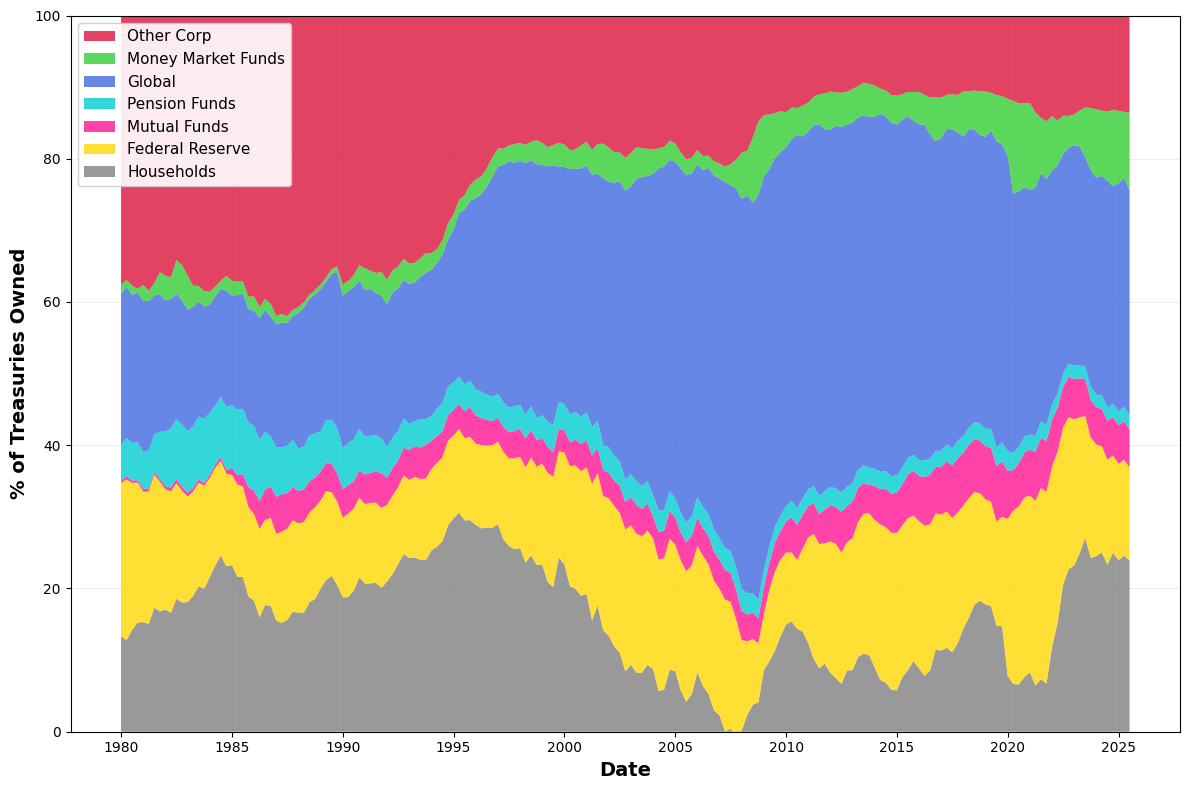

Figure saved to figures/treasury_ownership_by_holder.png


In [6]:
# Prepare data for stacked area chart (matching the order in the legend)
# Order from bottom to top: Households, Federal Reserve, Mutual Funds, Pension Funds, Global, Money Market Funds, Other Corp
plot_order = ['Households', 'Federal Reserve', 'Mutual Funds', 'Pension Funds', 'Global', 'Money Market Funds', 'Other Corp']

# Define colors to match the original chart
colors = {
    'Households': '#808080',  # Gray
    'Federal Reserve': '#FFD700',  # Gold/Yellow
    'Mutual Funds': '#FF1493',  # Magenta
    'Pension Funds': '#00CED1',  # Cyan
    'Global': '#4169E1',  # Blue
    'Money Market Funds': '#32CD32',  # Green
    'Other Corp': '#DC143C'  # Red
}

# Create the figure
fig, ax = plt.subplots(figsize=(12, 8))

# Filter data to 1980-2020 to match original chart
df_plot = df_pct.loc['1980':'2025', plot_order]

# Create stacked area chart
ax.stackplot(df_plot.index, 
             [df_plot[col] for col in plot_order],
             labels=plot_order,
             colors=[colors[col] for col in plot_order],
             alpha=0.8)

# Customize the plot
ax.set_xlabel('Date', fontsize=14, fontweight='bold')
ax.set_ylabel('% of Treasuries Owned', fontsize=14, fontweight='bold')
ax.set_ylim(0, 100)
ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
ax.set_axisbelow(True)

# Create legend with reversed order (to match visual stacking)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='upper left', fontsize=11, framealpha=0.9)

plt.tight_layout()
plt.savefig('../figures/treasury_ownership_by_holder.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved to figures/treasury_ownership_by_holder.png")

## Corporate Bonds

## FRED Series IDs for Corporate and Foreign Bond Holdings

Based on the Federal Reserve's Financial Accounts (Z.1), Table L.213:

- **BOGZ1FL893063005A**: All Sectors; Corporate and Foreign Bonds (Total, for calculating percentages)
- **BOGZ1LM543063005Q**: Life Insurance Companies
- **BOGZ1LM573063005Q**: Private Pension Funds
- **BOGZ1LM223063005Q**: State and Local Government Employee Retirement Funds
- **BOGZ1LM513061105Q**: Property-Casualty Insurance Companies
- **BOGZ1LM653063005Q**: Mutual Funds (confirmed from search)
- **BOGZ1LM633063005Q**: Money Market Funds
- **BOGZ1FL643063005Q**: ETFs (Exchange-Traded Funds)
- **BOGZ1LM763063005Q**: U.S.-Chartered Depository Institutions (Banks)
- **BOGZ1LM713063005Q**: Broker-Dealers
- **BOGZ1LM263063005Q**: Rest of World
- **CFBABSHNO** or **HNOCFBA027N**: Households and Nonprofit Organizations (or calculated as residual)

In [27]:
# Define FRED series IDs for Corporate and Foreign Bond holdings by sector (from Z.1 Table L.213)
corp_bond_series = {
    'Total': 'BOGZ1FL893063005A',  # All sectors total
    'Life': 'BOGZ1LM543063005Q',  # Life insurance companies
    'Pension': 'BOGZ1LM573063005Q',  # Private pension funds
    #'State/Local Pension': 'QPRHLDCBDBNDHOLDINGSUSNO',  # State and local govt pension
    'PC Insurance': 'BOGZ1LM513063005Q',  # Property-casualty insurance
    'Mutual Fund': 'BOGZ1LM653063005Q',  # Mutual funds
    'Money Market': 'BOGZ1FL633063005Q',  # Money market funds
    'ETF': 'BOGZ1FL643063005Q',  # ETFs
    'Bank': 'BOGZ1LM763063005Q',  # U.S.-chartered depository institutions
    'Broker Dealer': 'BOGZ1LM663063005Q',  # Security brokers and dealers
    'Rest of World': 'BOGZ1LM263063005Q',  # Foreign holdings
    'Government': 'BOGZ1LM213063003A',  # State and local governments (general)
}

# Fetch corporate bond data from FRED
corp_data = {}
for name, series_id in corp_bond_series.items():
    try:
        series = fred.get_series(series_id, observation_start='2000-01-01')
        corp_data[name] = series
        print(f"Fetched {name}: {len(series)} observations")
    except Exception as e:
        print(f"Error fetching {name} ({series_id}): {e}")

# Create DataFrame for corporate bonds
df_corp = pd.DataFrame(corp_data)
print(f"\nCorporate Bonds DataFrame shape: {df_corp.shape}")
print(f"Date range: {df_corp.index.min()} to {df_corp.index.max()}")

Fetched Total: 25 observations
Fetched Life: 103 observations
Fetched Pension: 103 observations
Fetched PC Insurance: 103 observations
Fetched Mutual Fund: 103 observations
Fetched Money Market: 103 observations
Fetched ETF: 94 observations
Fetched Bank: 103 observations
Fetched Broker Dealer: 103 observations
Fetched Rest of World: 103 observations
Fetched Government: 25 observations

Corporate Bonds DataFrame shape: (103, 11)
Date range: 2000-01-01 00:00:00 to 2025-07-01 00:00:00


In [29]:
# Combine pension funds and aggregate other categories to match the chart
#df_corp[''] = df_corp['Pension'] #+ df_corp['State/Local Pension']
df_corp['PC'] = df_corp['PC Insurance']  # Rename for brevity
df_corp['Other'] = df_corp['Government']  # Simplify "Other" category

# Calculate Household as residual
measured_corp_sectors = ['Life', 'Pension', 'PC', 'Mutual Fund', 'ETF', 
                         'Money Market', 'Bank', 'Broker Dealer', 'Rest of World', 'Other']
df_corp['Household'] = df_corp['Total'] - df_corp[measured_corp_sectors].sum(axis=1)

# Calculate percentages
df_corp_pct = pd.DataFrame(index=df_corp.index)
corp_sectors = ['Life', 'Pension', 'PC', 'Government', 'Bank', 
                'Mutual Fund', 'ETF', 'Money Market', 'Household', 'Broker Dealer', 
                'Rest of World', 'Other']

for col in corp_sectors:
    if col in df_corp.columns:
        df_corp_pct[col] = (df_corp[col] / df_corp['Total']) * 100

print("Corporate bond percentage data calculated")
print("\nLast 5 observations:")
df_corp_pct.tail()

Corporate bond percentage data calculated

Last 5 observations:


,Life,Pension,PC,Government,Bank,Mutual Fund,ETF,Money Market,Household,Broker Dealer,Rest of World,Other
2024-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
# Check for missing data
print("Missing values per column:")
print(df_corp.isnull().sum())

# Forward fill missing values
df_corp = df_corp.ffill()

# Display first few rows
print("\nFirst few observations:")
df_corp.tail()

Missing values per column:
Total            78
Life              0
Pension           0
PC Insurance      0
Mutual Fund       0
Money Market      0
ETF               9
Bank              0
Broker Dealer     0
Rest of World     0
Government       78
PC                0
Other            78
Household        78
dtype: int64

First few observations:


,Total,Life,Pension,PC Insurance,Mutual Fund,Money Market,ETF,Bank,Broker Dealer,Rest of World,Government,PC,Other,Household
2024-07-01,15188396.0,3644698.0,906326.0,802828.0,2393714.0,9346.0,26965.0,757459.0,68533.0,4422754.0,298301.0,802828.0,298301.0,2404779.0
2024-10-01,15188396.0,3534986.0,876672.0,783039.0,2327417.0,7300.0,26965.0,676852.0,65457.0,4295420.0,298301.0,783039.0,298301.0,2404779.0
2025-01-01,15188396.0,3629499.0,896013.0,812863.0,2412002.0,7526.0,26965.0,758417.0,69398.0,4414913.0,298301.0,812863.0,298301.0,2404779.0
2025-04-01,15188396.0,3726224.0,912777.0,831762.0,2438012.0,9130.0,26965.0,747485.0,77231.0,4617680.0,298301.0,831762.0,298301.0,2404779.0
2025-07-01,15188396.0,3854459.0,935484.0,871265.0,2532381.0,12674.0,26965.0,743780.0,77611.0,4768001.0,298301.0,871265.0,298301.0,2404779.0


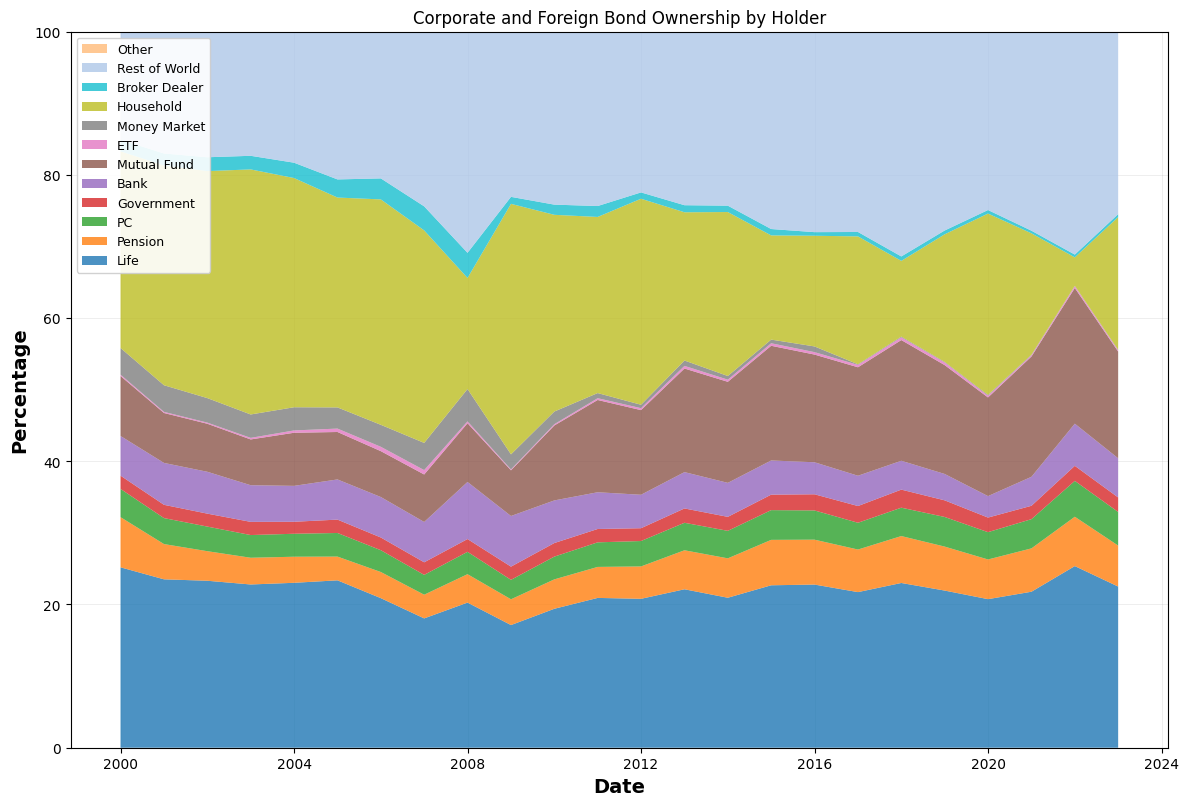

Figure saved to figures/corporate_bond_ownership_by_holder.png


In [33]:
# Create stacked area chart for corporate bonds (matching the order in the image)
# From bottom to top based on the legend
plot_order_corp = ['Life', 'Pension', 'PC', 'Government', 'Bank', 
                   'Mutual Fund', 'ETF', 'Money Market', 'Household', 'Broker Dealer', 
                   'Rest of World', 'Other']

# Define colors to match the chart (estimated from image)
colors_corp = {
    'Life': '#1f77b4',          # Blue
    'Pension': '#ff7f0e',       # Orange
    'PC': '#2ca02c',            # Green
    'Government': '#d62728',    # Red
    'Bank': '#9467bd',          # Purple
    'Mutual Fund': '#8c564b',   # Brown
    'ETF': '#e377c2',           # Pink
    'Money Market': '#7f7f7f',  # Gray
    'Household': '#bcbd22',     # Yellow-green
    'Broker Dealer': '#17becf', # Cyan
    'Rest of World': '#aec7e8', # Light blue
    'Other': '#ffbb78'          # Light orange
}

# Create the figure
fig, ax = plt.subplots(figsize=(12, 8))

# Filter data to 2000-2018 to match original chart
df_plot_corp = df_corp_pct.loc['2000':'2025'].dropna()

# Filter to only columns that exist
plot_cols = [col for col in plot_order_corp if col in df_plot_corp.columns]

# Create stacked area chart
ax.stackplot(df_plot_corp.index, 
             [df_plot_corp[col] for col in plot_cols],
             labels=plot_cols,
             colors=[colors_corp.get(col, '#CCCCCC') for col in plot_cols],
             alpha=0.8)

# Customize the plot
ax.set_xlabel('Date', fontsize=14, fontweight='bold')
ax.set_ylabel('Percentage', fontsize=14, fontweight='bold')
ax.set_ylim(0, 100)
ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
ax.set_axisbelow(True)

# Create legend with reversed order (to match visual stacking)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='upper left', fontsize=9, framealpha=0.9, ncol=1)

plt.tight_layout()
plt.title('Corporate and Foreign Bond Ownership by Holder')
plt.savefig('../figures/corporate_bond_ownership_by_holder.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved to figures/corporate_bond_ownership_by_holder.png")